## препроц

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import seaborn as sns


In [3]:
df = pq.read_table(source='train_ai_comp_final_dp.parquet').to_pandas().drop(['id', 'sample_ml_new'], axis=1)

In [4]:
df_test = pq.read_table(source='test_sber.parquet').to_pandas().drop(['id', 'sample_ml_new'], axis=1)

In [5]:
ids = pq.read_table(source='test_sber.parquet').to_pandas()['id']

In [6]:
columns_with_nan = df.columns[df.isna().any()].tolist()


In [7]:
columns_with_nan

['feature642', 'feature756']

In [8]:
from sklearn.impute import SimpleImputer

# Создание экземпляра SimpleImputer с выбранным стратегией заполнения (например, среднее значение)
imputer = SimpleImputer(strategy='median')

# Применение импутера к столбцу с пропущенными значениями
df[columns_with_nan[0]] = imputer.fit_transform(df[[columns_with_nan[0]]])

In [9]:
df_test[columns_with_nan[0]] = imputer.transform(df_test[[columns_with_nan[0]]])


In [10]:
columns_with_nan = df.columns[df.isna().any()].tolist()


In [11]:
columns_with_nan

['feature756']

In [12]:
df = df.drop(columns_with_nan, axis=1).reset_index(drop=True)
df_test = df_test.drop(columns_with_nan, axis=1).reset_index(drop=True)


In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, MaxAbsScaler, PowerTransformer


In [14]:
categorical_features = [col for col in df.columns[1:] if df[col].nunique() < 20]
numerical_features = [col for col in df.columns[1:] if df[col].nunique() >= 20]

In [15]:
from tqdm import tqdm

In [16]:
# Применение всех методов масштабирования
scalers = {
    #"StandardScaler": StandardScaler(),
    #"MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler(),
    #"Normalizer": Normalizer(),
    #"MaxAbsScaler": MaxAbsScaler(),
}

scaled_dfs = []

for scaler_name, scaler in tqdm(scalers.items()):
    scaled_data = scaler.fit_transform(df[numerical_features])
    scaled_df = pd.DataFrame(scaled_data, columns=[f"{feature}_{scaler_name}" for feature in numerical_features])
    scaled_dfs.append((scaler_name, scaled_df))
    
# Объединение результатов
df = pd.concat([df] + [scaled_df for _, scaled_df in scaled_dfs], axis=1)


100%|██████████| 1/1 [00:06<00:00,  6.68s/it]


In [17]:
scaled_dfs_test = []

for scaler_name, scaler in tqdm(scalers.items()):
    scaled_data_test = scaler.transform(df_test[numerical_features])
    scaled_df_test = pd.DataFrame(scaled_data_test, columns=[f"{feature}_{scaler_name}" for feature in numerical_features])
    scaled_dfs_test.append((scaler_name, scaled_df_test))
    
# Объединение результатов масштабирования с df_test
df_test = pd.concat([df_test] + [scaled_df_test for _, scaled_df_test in scaled_dfs_test], axis=1)

100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


In [18]:
len(categorical_features)

348

In [19]:
from sklearn.preprocessing import OneHotEncoder


In [20]:
# Метод Label Encoding
for feature in categorical_features:
    df[feature + '_label_encoded'] = df[feature].astype('category').cat.codes

# Метод One-Hot Encoding
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_features = pd.DataFrame(encoder.fit_transform(df[categorical_features]))
encoded_features.columns = encoder.get_feature_names_out(categorical_features)

df = pd.concat([df, encoded_features], axis=1)

/tmp/ipykernel_1972557/494848116.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature + '_label_encoded'] = df[feature].astype('category').cat.codes
/tmp/ipykernel_1972557/494848116.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature + '_label_encoded'] = df[feature].astype('category').cat.codes
/tmp/ipykernel_1972557/494848116.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns a

In [21]:
for feature in categorical_features:
    df_test[feature + '_label_encoded'] = df_test[feature].astype('category').cat.codes

# Метод One-Hot Encoding для df_test
encoded_features_test = pd.DataFrame(encoder.transform(df_test[categorical_features]))
encoded_features_test.columns = encoder.get_feature_names_out(categorical_features)

df_test = pd.concat([df_test, encoded_features_test], axis=1)

/tmp/ipykernel_1972557/2541961053.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[feature + '_label_encoded'] = df_test[feature].astype('category').cat.codes
/tmp/ipykernel_1972557/2541961053.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[feature + '_label_encoded'] = df_test[feature].astype('category').cat.codes
/tmp/ipykernel_1972557/2541961053.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

In [24]:
df_test

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature1031_0,feature1032_0,feature1033_0,feature1034_0,feature1037_0,feature1037_19232,feature1044_0,feature1044_3901,feature1058_0,feature1058_10091
0,1696,458,26,102479,22,16,0,121,69,0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1688,53,78,103922,191,64,0,0,65,0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1689,13,81,104111,191,4,0,0,125,0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,1761,1759,44,102433,191,4,0,0,135,0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4,1761,1759,77,102010,191,34,0,0,83,0,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173428,1761,1759,141,220,191,0,125,290,298,176,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
173429,1761,1759,141,174,191,1,125,290,298,176,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
173430,1761,1759,141,74,191,1,125,290,298,176,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
173431,1761,1759,141,107,191,1,125,290,298,176,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


In [25]:
df

,target,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature1031_0,feature1032_0,feature1033_0,feature1034_0,feature1037_0,feature1037_19232,feature1044_0,feature1044_3901,feature1058_0,feature1058_10091
0,0,1761,1759,85,105469,191,46,0,6,95,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0,1761,1759,120,105610,144,71,0,135,135,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0,890,1759,141,105227,191,11,0,0,0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0,1599,966,30,102441,191,8,0,0,0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0,1761,1759,85,104006,191,2,0,0,46,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519610,0,1761,1759,141,410,191,2,125,290,298,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
519611,0,1761,1759,0,170,191,1,125,290,298,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
519612,0,1761,1759,0,168,191,1,125,290,298,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
519613,0,1761,1759,141,74,191,1,125,290,298,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


## кэтбуст

In [26]:
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt

# Разделение данных на тренировочный и валидационный наборы
X_train, X_val, y_train, y_val = train_test_split(df.drop(['target'], axis=1), df['target'], test_size=0.1, random_state=0)


In [20]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# Создание модели XGBoost
model_xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05, max_depth=4, random_state=0)

# Обучение модели с выводом логов и графика
eval_set = [(X_train, y_train), (X_val, y_val)]  # Указываем обучающий и валидационный наборы данных
model_xgb.fit(X_train, y_train, eval_set=eval_set, eval_metric="auc", verbose=True)

# Получение предсказаний на валидационном наборе данных
val_preds_xgb = model_xgb.predict_proba(X_val)[:, 1]

# Вычисление ROC-AUC на валидационном наборе данных
roc_auc_xgb = roc_auc_score(y_val, val_preds_xgb)
print("ROC-AUC на валидационном наборе данных (XGBoost):", roc_auc_xgb)

/home/andrew/.local/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x7ff5a476afd0>>
Traceback (most recent call last):
  File "/home/andrew/.local/lib/python3.11/site-packages/xgboost/core.py", line 589, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument

KeyboardInterrupt: 


XGBoostError: [13:53:09] /workspace/src/data/iterative_dmatrix.cc:262: Check failed: rbegin == Info().num_row_ (103923 vs. 207846) : 
Stack trace:
  [bt] (0) /home/andrew/.local/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x7ff2435effba]
  [bt] (1) /home/andrew/.local/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0x3f6eef) [0x7ff2435f6eef]
  [bt] (2) /home/andrew/.local/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x7ff2435f8858]
  [bt] (3) /home/andrew/.local/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x7ff2435a2a07]
  [bt] (4) /home/andrew/.local/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x7ff243365c40]
  [bt] (5) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7ff6dd5aee2e]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7ff6dd5ab493]
  [bt] (7) /usr/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0xa4d8) [0x7ff6dd83a4d8]
  [bt] (8) /usr/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0x9c8e) [0x7ff6dd839c8e]



In [31]:
X_train

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature1067_MaxAbsScaler,feature1068_MaxAbsScaler,feature1069_MaxAbsScaler,feature1070_MaxAbsScaler,feature1071_MaxAbsScaler,feature1072_MaxAbsScaler,feature1073_MaxAbsScaler,feature1074_MaxAbsScaler,feature1075_MaxAbsScaler,feature1076_MaxAbsScaler
326139,1332,30,119,104904,30,14,0,0,119,0,...,0.169613,0.137221,0.899831,0.293634,0.000000,0.000000,0.205353,0.169613,0.137221,0.899831
219308,1761,1759,66,102224,191,3,0,0,37,0,...,0.055004,0.049701,0.057630,0.079204,0.000000,0.000000,0.061522,0.055004,0.049701,0.057630
137074,1533,119,141,102173,191,73,0,187,122,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
286190,932,817,118,103782,191,6,0,29,19,0,...,0.058282,0.052697,0.360019,0.000000,0.026706,0.053293,0.024377,0.058282,0.052697,0.360019
511455,1428,974,141,45514,191,2,125,290,298,176,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439107,1224,1759,83,99683,191,119,125,290,298,176,...,0.632576,0.683709,0.803728,0.662706,0.016239,0.615829,0.551237,0.632576,0.683709,0.803728
117952,1637,15,93,105450,191,20,125,290,298,176,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
435829,1761,1759,92,102403,191,15,0,0,0,0,...,0.000000,0.000000,0.877451,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.877451
305711,1761,1759,141,104767,191,31,125,290,298,176,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [32]:
X_train[categorical_features]

,feature23,feature26,feature27,feature28,feature68,feature69,feature144,feature160,feature232,feature235,...,feature1028,feature1029,feature1030,feature1031,feature1032,feature1033,feature1034,feature1037,feature1044,feature1058
326139,7,3,6,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
219308,7,3,6,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
137074,7,3,6,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
286190,7,3,6,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
511455,7,3,6,7,0,0,0,0,2,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439107,7,3,6,7,0,0,0,0,2,1,...,0,0,0,0,0,0,0,0,0,0
117952,7,3,6,7,0,0,0,0,2,1,...,0,0,0,0,0,0,0,0,0,0
435829,7,3,6,7,0,0,0,0,2,1,...,0,0,0,0,0,0,0,0,0,0
305711,7,3,6,7,0,0,0,0,2,1,...,0,0,0,0,0,0,0,0,0,0


In [25]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_)

In [26]:
weights

array([ 0.51845884, 14.04364865])

In [27]:
# Создание и обучение модели CatBoost с учетом дисбаланса классов и использованием GPU
model = CatBoostClassifier(iterations=7500,
                           learning_rate=0.01,
                           depth=6,
                           loss_function='MultiClass',
                           eval_metric='AUC',
                           random_seed=0,
                           class_weights=[1, 12],  # примерное соотношение классов
                           task_type='GPU')  # использование GPU


# Создание Pool объектов для тренировочного и валидационного наборов данных
train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)

# Обучение модели
model.fit(train_pool, eval_set=val_pool, plot=True)

# Получение предсказаний на валидационном наборе данных
val_preds = model.predict_proba(X_val)[:, 1]

# Вычисление ROC-AUC на валидационном наборе данных
roc_auc = roc_auc_score(y_val, val_preds)
print("ROC-AUC на валидационном наборе данных:", roc_auc)

# Отображение графика
plt.show()



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7114691	best: 0.7114691 (0)	total: 31.9ms	remaining: 3m 58s
1:	total: 58.6ms	remaining: 3m 39s
2:	total: 84ms	remaining: 3m 29s
3:	total: 109ms	remaining: 3m 24s
4:	total: 132ms	remaining: 3m 18s
5:	test: 0.7181604	best: 0.7181604 (5)	total: 158ms	remaining: 3m 17s
6:	total: 184ms	remaining: 3m 16s
7:	total: 208ms	remaining: 3m 15s
8:	total: 234ms	remaining: 3m 14s
9:	total: 258ms	remaining: 3m 13s
10:	test: 0.7228187	best: 0.7228187 (10)	total: 284ms	remaining: 3m 13s
11:	total: 308ms	remaining: 3m 12s
12:	total: 333ms	remaining: 3m 11s
13:	total: 357ms	remaining: 3m 11s
14:	total: 382ms	remaining: 3m 10s
15:	test: 0.7226063	best: 0.7228187 (10)	total: 408ms	remaining: 3m 10s
16:	total: 433ms	remaining: 3m 10s
17:	total: 455ms	remaining: 3m 9s
18:	total: 480ms	remaining: 3m 8s
19:	total: 502ms	remaining: 3m 7s
20:	test: 0.7238922	best: 0.7238922 (20)	total: 528ms	remaining: 3m 7s
21:	total: 552ms	remaining: 3m 7s
22:	total: 576ms	remaining: 3m 7s
23:	total: 601ms	remaining:

In [32]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Получение вероятностей положительного класса на валидационном наборе данных
val_preds = model.predict_proba(X_val)[:, 1]

# Вычисление precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_val, val_preds)

# Вычисление F1-меры для каждого порога
f1_scores = 2 * (precision * recall) / (precision + recall)

# Нахождение индекса порога, при котором F1-мера максимальна
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]

print("Best Threshold:", best_threshold)
print("Best F1-Score:", f1_scores[best_threshold_index])


Best Threshold: 0.5545745792049883
Best F1-Score: 0.21777114851907095


In [34]:
pred = model.predict_proba(df_test)

pred = pred[:, 1]
pred_binary = (pred >= best_threshold).astype(int)

In [35]:
submission = pd.read_csv("sample_submission.csv")
submission["target_prob"] = pred
submission["target_bin"] = pred_binary
submission.to_csv("submission.csv", index=False)

In [18]:
feature_importance = model.feature_importances_

# Создание DataFrame для удобства анализа
fi_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Сортировка по важности
fi_df = fi_df.sort_values(by='Importance', ascending=False)

# Вывод результата
print(fi_df)

                       Feature  Importance
1002               feature1004    2.530380
340                 feature341    2.410983
318                 feature319    2.067782
992                 feature994    1.842507
948                 feature950    1.470493
...                        ...         ...
976                 feature978    0.000000
977                 feature979    0.000000
978                 feature980    0.000000
1417   feature372_RobustScaler    0.000000
1801  feature1076_RobustScaler    0.000000

[1802 rows x 2 columns]


In [22]:
fi_df[fi_df['Importance']==0]

,Feature,Importance
1616,feature824_RobustScaler,0.0
1644,feature852_RobustScaler,0.0
1638,feature846_RobustScaler,0.0
624,feature625,0.0
1640,feature848_RobustScaler,0.0
...,...,...
976,feature978,0.0
977,feature979,0.0
978,feature980,0.0
1417,feature372_RobustScaler,0.0


In [56]:
%pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 KB 1.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 17.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.0/215.0 KB 15.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


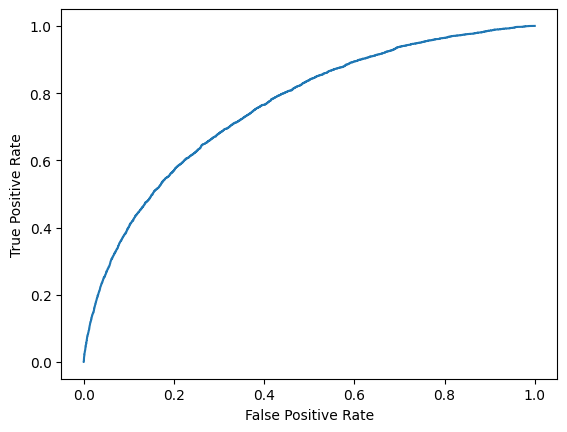

In [18]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve (y_val, val_preds)
auc = metrics.roc_auc_score (y_val, val_preds)

#create ROC curve
plt.plot (fpr,tpr,label=" AUC= "+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

## нейронка

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from torch.utils.data import Dataset, TensorDataset
from sklearn import preprocessing

#df = pq.read_table(source='train_ai_comp_final_dp.parquet').to_pandas()
# Предположим, что у вас уже есть данные df, подготовленные для обучения модели

df = df.dropna(axis=1)
all_X = df.drop(['target'], axis=1)
all_y = df['target']

X_train, X_val, y_train, y_val = train_test_split(all_X, all_y, test_size=0.2, random_state=0)

In [15]:
#scaler = preprocessing.MinMaxScaler()
#X_train = scaler.fit_transform(X_train.values)
#X_val =  scaler.fit_transform(X_val.values)

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Define your neural network model
class Classifier(nn.Module):
    def __init__(self, input_size):
        super(Classifier, self).__init__()
        self.fc0 = nn.Linear(input_size, 1028)
        self.fc1 = nn.Linear(1028, 256)
        self.fc2 = nn.Linear(256, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)  # Adding dropout for regularization

    def forward(self, x):
        x = torch.relu(self.fc0(x))
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc3(x))
        return x
    
    def get_embed(self, x):
        x = torch.relu(self.fc0(x))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return x
    
# Define your dataset
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]




In [26]:
bs = 32000

# Move model and data to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Classifier(input_size=X_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_dataset = CustomDataset(X_train.values, y_train.values)
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

val_dataset = CustomDataset(X_val.values, y_val.values)
val_loader = DataLoader(val_dataset, batch_size=bs)

all_loader = DataLoader(CustomDataset(all_X.values, all_y.values), batch_size=bs)


Epoch 1/10, Loss: 0.2802
Validation ROC AUC: 0.6780


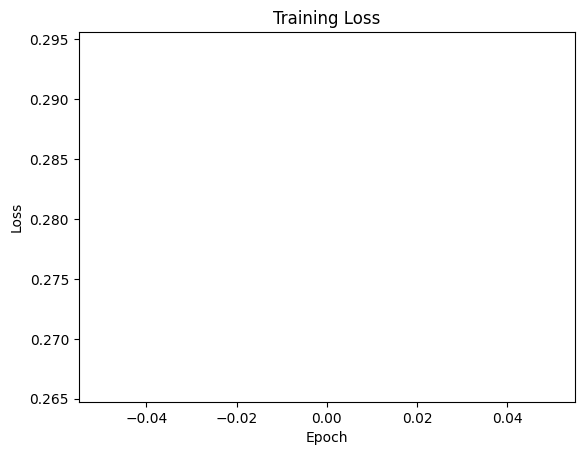

Epoch 2/10, Loss: 0.1782
Validation ROC AUC: 0.6914


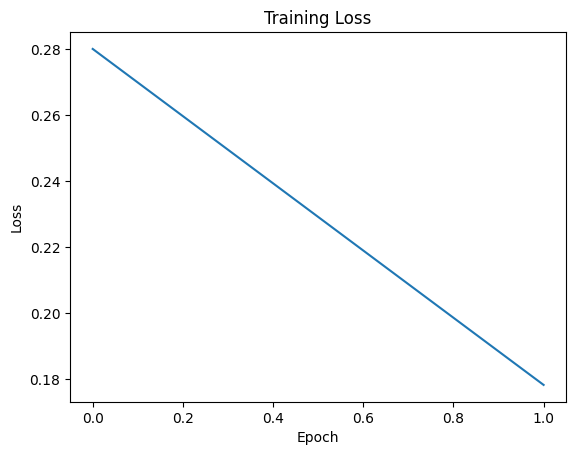

Epoch 3/10, Loss: 0.1661
Validation ROC AUC: 0.7109


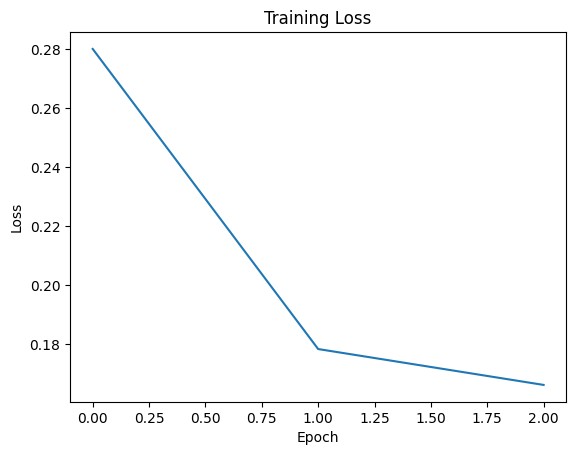

Epoch 4/10, Loss: 0.1610
Validation ROC AUC: 0.7177


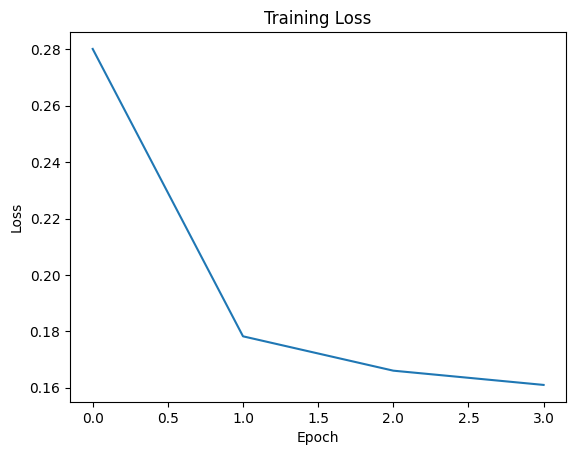

Epoch 5/10, Loss: 0.1590
Validation ROC AUC: 0.7223


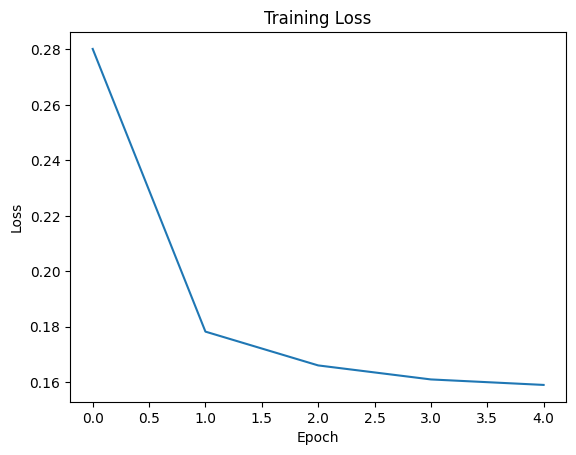

Epoch 6/10, Loss: 0.1574
Validation ROC AUC: 0.7253


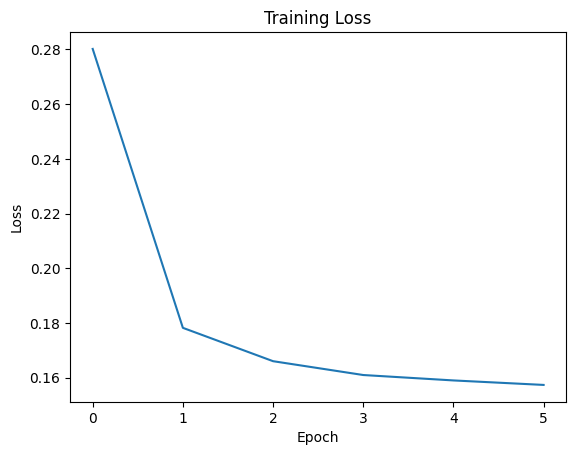

Epoch 7/10, Loss: 0.1568
Validation ROC AUC: 0.7264


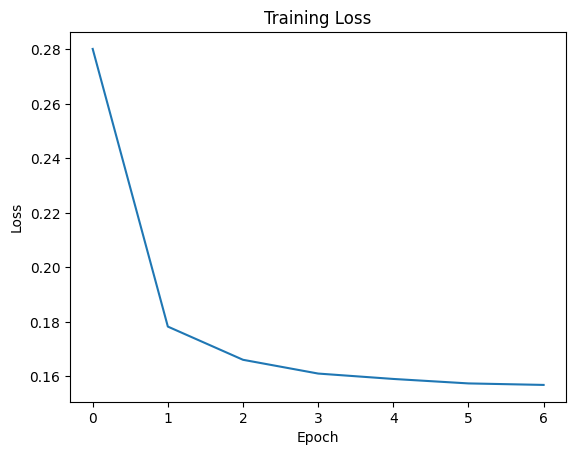

Epoch 8/10, Loss: 0.1556
Validation ROC AUC: 0.7281


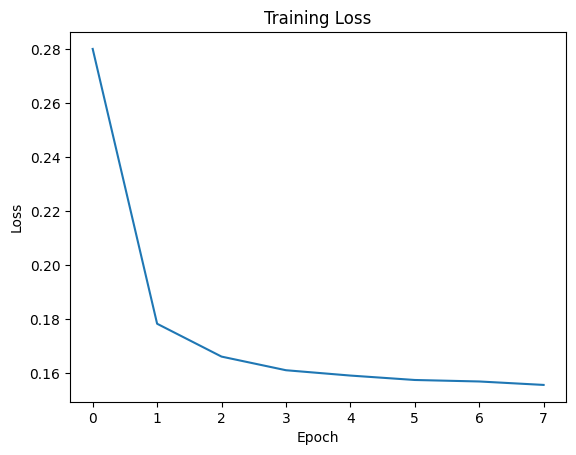

Epoch 9/10, Loss: 0.1553
Validation ROC AUC: 0.7295


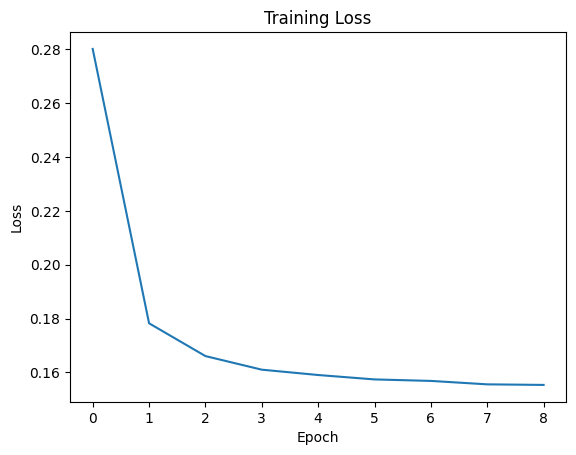

Epoch 10/10, Loss: 0.1547
Validation ROC AUC: 0.7294


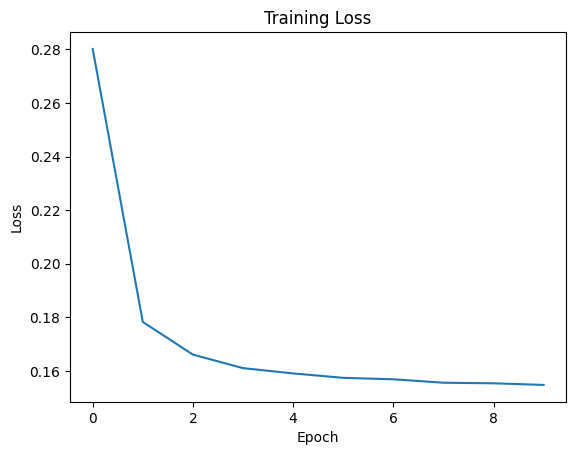

In [27]:
# Training loop
num_epochs = 10
train_losses = []


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    # Evaluation


    model.eval()
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_preds.extend(outputs.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # Calculate ROC AUC score
    roc_auc = roc_auc_score(val_labels, val_preds)
    print(f"Validation ROC AUC: {roc_auc:.4f}")

    # Plot training loss
    plt.plot(train_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()



In [28]:
import torch
import pandas as pd

# Предположим, что all_loader уже определен

embeddings_list = []
labels_list = []

# Перевод модели на устройство
model.to(device)
model.eval()

with torch.no_grad():
    for inputs, labels in all_loader:
        inputs = inputs.to(device)
        labels = labels.cpu().numpy()
        embeddings = model.get_embed(inputs).cpu().numpy()
        
        embeddings_list.append(embeddings)
        labels_list.append(labels)

# Преобразование списков в один массив
embeddings_array = np.concatenate(embeddings_list, axis=0)
labels_array = np.concatenate(labels_list, axis=0)

# Создание DataFrame
df_embeddings = pd.DataFrame(embeddings_array)
df_labels = pd.DataFrame(labels_array, columns=['label'])

# Объединение эмбеддингов и меток в один DataFrame
df_feathes = pd.concat([df_embeddings, df_labels], axis=1)



In [29]:
df_feathes.describe()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,label
count,519615.0,519615.000000,519615.000000,519615.0,519615.0,519615.0,519615.000000,519615.0,519615.0,519615.000000,...,519615.000000,519615.0,519615.000000,519615.000000,519615.0,519615.000000,519615.000000,519615.0,519615.000000,519615.000000
mean,0.0,1.557384,4.648276,0.0,0.0,0.0,2.164557,0.0,0.0,1.935286,...,1.743636,0.0,2.061306,3.670993,0.0,3.397405,3.056867,0.0,3.915422,0.035674
std,0.0,0.432614,1.289618,0.0,0.0,0.0,0.591855,0.0,0.0,0.561098,...,0.478484,0.0,0.596575,1.053944,0.0,0.953970,0.853467,0.0,1.111377,0.185477
min,0.0,0.098618,0.354878,0.0,0.0,0.0,0.187967,0.0,0.0,0.122022,...,0.162520,0.0,0.145555,0.288611,0.0,0.229235,0.262894,0.0,0.334469,0.000000
25%,0.0,1.285106,3.823305,0.0,0.0,0.0,1.787701,0.0,0.0,1.576233,...,1.439126,0.0,1.671166,2.991100,0.0,2.788052,2.508739,0.0,3.204753,0.000000
50%,0.0,1.572927,4.671526,0.0,0.0,0.0,2.178338,0.0,0.0,1.947556,...,1.753351,0.0,2.071609,3.686788,0.0,3.417624,3.078389,0.0,3.941395,0.000000
75%,0.0,1.835784,5.472452,0.0,0.0,0.0,2.544994,0.0,0.0,2.295143,...,2.049536,0.0,2.452819,4.347790,0.0,4.007856,3.611390,0.0,4.628308,0.000000
max,0.0,22.016491,48.083897,0.0,0.0,0.0,24.588112,0.0,0.0,22.088249,...,22.101852,0.0,18.168249,33.642345,0.0,32.246937,26.915016,0.0,41.095787,1.000000


In [30]:
df_feathes.loc[:, (df_feathes != 0).any(axis=0)]

,1,2,6,9,10,14,15,17,18,20,23,25,26,28,29,31,label
0,1.581020,4.342388,2.180788,1.904400,1.405148,3.101849,5.513533,1.884010,3.894029,2.462109,1.742550,2.131557,3.690019,3.206530,2.863522,3.843671,0.0
1,1.470342,4.834973,2.216972,2.043361,1.576756,3.352593,5.629570,2.178501,4.219778,2.574083,1.788471,2.164435,3.819014,3.547324,3.240658,3.964748,0.0
2,1.091102,3.065522,1.516210,1.180953,1.003989,2.244043,3.790945,1.348252,2.709065,1.671839,1.141203,1.421591,2.454521,2.252214,1.956937,2.551668,0.0
3,0.663078,1.981124,0.932512,0.755993,0.690286,1.408144,2.421953,0.870534,1.664708,0.984479,0.780195,0.864889,1.453326,1.365711,1.327995,1.582612,0.0
4,0.998794,2.533469,1.230078,1.078992,0.869447,1.883833,3.212549,1.137324,2.223409,1.472350,0.986275,1.198912,2.113451,1.932641,1.714694,2.217319,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519610,0.655472,2.041813,0.935974,0.742938,0.701408,1.500585,2.441353,0.885637,1.762601,0.955694,0.757278,0.873427,1.502694,1.470127,1.418015,1.605890,0.0
519611,1.150404,3.751858,1.880658,1.386196,1.134331,2.584557,4.331614,1.503539,3.018871,1.730382,1.458368,1.527954,2.900175,2.696572,2.315543,2.930166,0.0
519612,1.173310,3.619373,1.790758,1.347052,1.096855,2.527518,4.209206,1.406910,2.840603,1.647000,1.409931,1.475637,2.797055,2.629566,2.177447,2.794514,0.0
519613,0.586091,1.932526,0.906291,0.714140,0.638169,1.398807,2.144660,0.712607,1.524907,0.860929,0.698790,0.689428,1.464385,1.342160,1.153054,1.560710,0.0


In [34]:
df_feathes = df_feathes.loc[:, (df_feathes != 0).any(axis=0)]

In [35]:
df_postproc_model = pd.concat([df_feathes, all_X], axis=1)

In [36]:
df_feathes

,1,2,6,8,12,17,21,23,26,28,...,230,235,237,238,239,241,244,247,255,label
0,0.568720,0.946476,0.615599,2.554008,0.512757,0.791827,2.570297,0.628346,0.932309,0.668826,...,0.000000,0.979094,0.603274,0.913219,2.583379,1.015500,2.211748,1.765886,0.600784,0.0
1,0.595206,0.976090,0.589102,2.701125,0.571889,0.805652,2.620447,0.674044,1.023423,0.634831,...,0.000000,1.008168,0.657479,0.851896,2.582799,0.988990,2.152536,1.747320,0.563598,0.0
2,0.397720,0.790011,0.437705,1.827584,0.365257,0.529169,1.771843,0.465256,0.686763,0.478267,...,0.000000,0.740003,0.453937,0.698649,1.870260,0.690285,1.455719,1.250630,0.378077,0.0
3,0.313093,0.516092,0.242391,1.249443,0.295624,0.371606,1.193459,0.336140,0.437613,0.298614,...,0.000000,0.474085,0.290982,0.429219,1.221944,0.459356,0.929472,0.770280,0.226934,0.0
4,0.334231,0.602038,0.350959,1.476635,0.344016,0.433481,1.564930,0.413338,0.577500,0.390051,...,0.000000,0.692454,0.393618,0.538869,1.588013,0.564518,1.249957,1.031450,0.324463,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519610,0.385806,0.460139,0.295517,1.274628,0.257004,0.374992,1.192289,0.398377,0.423387,0.346611,...,0.000000,0.545823,0.281038,0.481634,1.275373,0.453863,0.999630,0.793842,0.231259,0.0
519611,0.745663,0.889512,0.540983,2.630027,0.627974,0.772339,2.470265,0.715291,0.875427,0.642221,...,0.007573,1.056447,0.456094,0.903247,2.618167,0.966977,2.066422,1.472259,0.560083,0.0
519612,0.730835,0.852840,0.583305,2.570274,0.609195,0.761262,2.445848,0.693555,0.882279,0.643950,...,0.010736,1.017524,0.442931,0.926501,2.535974,0.961702,2.015256,1.466803,0.539610,0.0
519613,0.409752,0.469848,0.323199,1.335664,0.283865,0.409036,1.288899,0.410912,0.401622,0.289917,...,0.000000,0.567215,0.232461,0.460055,1.364378,0.464263,1.105611,0.731829,0.337507,0.0


## кэтбуст

In [36]:
df_postproc_model

,1,2,6,9,10,14,15,17,18,20,...,feature1031_0,feature1032_0,feature1033_0,feature1034_0,feature1037_0,feature1037_19232,feature1044_0,feature1044_3901,feature1058_0,feature1058_10091
0,1.581020,4.342388,2.180788,1.904400,1.405148,3.101849,5.513533,1.884010,3.894029,2.462109,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1.470342,4.834973,2.216972,2.043361,1.576756,3.352593,5.629570,2.178501,4.219778,2.574083,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1.091102,3.065522,1.516210,1.180953,1.003989,2.244043,3.790945,1.348252,2.709065,1.671839,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.663078,1.981124,0.932512,0.755993,0.690286,1.408144,2.421953,0.870534,1.664708,0.984479,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.998794,2.533469,1.230078,1.078992,0.869447,1.883833,3.212549,1.137324,2.223409,1.472350,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519610,0.655472,2.041813,0.935974,0.742938,0.701408,1.500585,2.441353,0.885637,1.762601,0.955694,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
519611,1.150404,3.751858,1.880658,1.386196,1.134331,2.584557,4.331614,1.503539,3.018871,1.730382,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
519612,1.173310,3.619373,1.790758,1.347052,1.096855,2.527518,4.209206,1.406910,2.840603,1.647000,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
519613,0.586091,1.932526,0.906291,0.714140,0.638169,1.398807,2.144660,0.712607,1.524907,0.860929,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


In [43]:
from sklearn.decomposition import PCA

# Применение метода PCA для уменьшения размерности
pca = PCA(n_components=100)  # Выбор числа компонент (признаков) для уменьшения
X_train_reduced = pca.fit_transform(df_postproc_model.drop(['label'], axis=1).values)

In [40]:
X_train_reduced

array([[ 5.71360782e+00, -3.19273955e+00,  3.29432976e+00, ...,
        -1.00026522e-01, -7.77150085e-01,  5.92379645e-03],
       [ 5.41930958e+00, -1.56498578e+00,  3.67404298e+00, ...,
        -5.61971646e-02, -9.17865633e-01,  1.30378790e-01],
       [-5.34856659e+00, -4.02269280e+00,  1.61195086e+00, ...,
        -1.76871968e+00, -1.84430220e+00, -1.29477953e+00],
       ...,
       [-2.01006690e+01, -6.88512140e+00,  6.99795486e-01, ...,
         3.30264106e+00,  9.34206920e+00,  6.47226029e+00],
       [-1.85011070e+01, -4.54584627e+00, -1.57818950e+00, ...,
         1.60835809e+00,  8.21848331e+00,  5.55365950e+00],
       [-1.86892813e+01, -5.97968679e+00, -3.04136856e+00, ...,
         3.99978965e+00,  1.66117857e+01,  7.66813000e+00]])

In [48]:
df_postproc_model

,1,2,6,9,10,14,15,17,18,20,...,feature1031_0,feature1032_0,feature1033_0,feature1034_0,feature1037_0,feature1037_19232,feature1044_0,feature1044_3901,feature1058_0,feature1058_10091
0,1.581020,4.342388,2.180788,1.904400,1.405148,3.101849,5.513533,1.884010,3.894029,2.462109,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1.470342,4.834973,2.216972,2.043361,1.576756,3.352593,5.629570,2.178501,4.219778,2.574083,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1.091102,3.065522,1.516210,1.180953,1.003989,2.244043,3.790945,1.348252,2.709065,1.671839,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.663078,1.981124,0.932512,0.755993,0.690286,1.408144,2.421953,0.870534,1.664708,0.984479,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.998794,2.533469,1.230078,1.078992,0.869447,1.883833,3.212549,1.137324,2.223409,1.472350,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519610,0.655472,2.041813,0.935974,0.742938,0.701408,1.500585,2.441353,0.885637,1.762601,0.955694,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
519611,1.150404,3.751858,1.880658,1.386196,1.134331,2.584557,4.331614,1.503539,3.018871,1.730382,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
519612,1.173310,3.619373,1.790758,1.347052,1.096855,2.527518,4.209206,1.406910,2.840603,1.647000,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
519613,0.586091,1.932526,0.906291,0.714140,0.638169,1.398807,2.144660,0.712607,1.524907,0.860929,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


In [52]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_mm = df_postproc_model.drop(['label'], axis=1)
df_mm.columns = df_mm.columns.astype(str)
df_postproc_model_scaled = pd.DataFrame(scaler.fit_transform(df_mm), columns=df_mm.columns)

In [59]:
df_mm

,1,2,6,9,10,14,15,17,18,20,...,feature1031_0,feature1032_0,feature1033_0,feature1034_0,feature1037_0,feature1037_19232,feature1044_0,feature1044_3901,feature1058_0,feature1058_10091
0,1.581020,4.342388,2.180788,1.904400,1.405148,3.101849,5.513533,1.884010,3.894029,2.462109,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1.470342,4.834973,2.216972,2.043361,1.576756,3.352593,5.629570,2.178501,4.219778,2.574083,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1.091102,3.065522,1.516210,1.180953,1.003989,2.244043,3.790945,1.348252,2.709065,1.671839,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.663078,1.981124,0.932512,0.755993,0.690286,1.408144,2.421953,0.870534,1.664708,0.984479,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.998794,2.533469,1.230078,1.078992,0.869447,1.883833,3.212549,1.137324,2.223409,1.472350,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519610,0.655472,2.041813,0.935974,0.742938,0.701408,1.500585,2.441353,0.885637,1.762601,0.955694,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
519611,1.150404,3.751858,1.880658,1.386196,1.134331,2.584557,4.331614,1.503539,3.018871,1.730382,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
519612,1.173310,3.619373,1.790758,1.347052,1.096855,2.527518,4.209206,1.406910,2.840603,1.647000,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
519613,0.586091,1.932526,0.906291,0.714140,0.638169,1.398807,2.144660,0.712607,1.524907,0.860929,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


In [62]:
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt

# Разделение данных на тренировочный и валидационный наборы
X_train, X_val, y_train, y_val = train_test_split(df_postproc_model_scaled, df_postproc_model['label'], test_size=0.2, random_state=0)

In [47]:
df_postproc_model

,1,2,6,9,10,14,15,17,18,20,...,feature1031_0,feature1032_0,feature1033_0,feature1034_0,feature1037_0,feature1037_19232,feature1044_0,feature1044_3901,feature1058_0,feature1058_10091
0,1.581020,4.342388,2.180788,1.904400,1.405148,3.101849,5.513533,1.884010,3.894029,2.462109,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1.470342,4.834973,2.216972,2.043361,1.576756,3.352593,5.629570,2.178501,4.219778,2.574083,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1.091102,3.065522,1.516210,1.180953,1.003989,2.244043,3.790945,1.348252,2.709065,1.671839,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.663078,1.981124,0.932512,0.755993,0.690286,1.408144,2.421953,0.870534,1.664708,0.984479,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.998794,2.533469,1.230078,1.078992,0.869447,1.883833,3.212549,1.137324,2.223409,1.472350,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519610,0.655472,2.041813,0.935974,0.742938,0.701408,1.500585,2.441353,0.885637,1.762601,0.955694,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
519611,1.150404,3.751858,1.880658,1.386196,1.134331,2.584557,4.331614,1.503539,3.018871,1.730382,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
519612,1.173310,3.619373,1.790758,1.347052,1.096855,2.527518,4.209206,1.406910,2.840603,1.647000,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
519613,0.586091,1.932526,0.906291,0.714140,0.638169,1.398807,2.144660,0.712607,1.524907,0.860929,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


In [54]:
# Создание и обучение модели CatBoost с учетом дисбаланса классов и использованием GPU
model = CatBoostClassifier(iterations=1500,
                           learning_rate=0.08,
                           depth=7,
                           loss_function='MultiClass',
                           eval_metric='AUC',
                           random_seed=0,
                           class_weights=[1, 1],  # примерное соотношение классов
                           task_type='GPU')  # использование GPU

# Создание Pool объектов для тренировочного и валидационного наборов данных
train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)

# Обучение модели
model.fit(train_pool, eval_set=val_pool)

# Получение предсказаний на валидационном наборе данных
val_preds = model.predict_proba(X_val)[:, 1]

# Вычисление ROC-AUC на валидационном наборе данных
roc_auc = roc_auc_score(y_val, val_preds)
print("ROC-AUC на валидационном наборе данных:", roc_auc)

# Отображение графика
plt.show()



Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7221896	best: 0.7221896 (0)	total: 16.8ms	remaining: 25.2s
1:	total: 29.7ms	remaining: 22.2s
2:	total: 41.3ms	remaining: 20.6s
3:	total: 54.1ms	remaining: 20.2s
4:	total: 69.3ms	remaining: 20.7s
5:	test: 0.7343304	best: 0.7343304 (5)	total: 85.3ms	remaining: 21.2s
6:	total: 98.5ms	remaining: 21s
7:	total: 113ms	remaining: 21.1s
8:	total: 127ms	remaining: 21s
9:	total: 142ms	remaining: 21.1s
10:	test: 0.7367937	best: 0.7367937 (10)	total: 159ms	remaining: 21.5s
11:	total: 176ms	remaining: 21.8s
12:	total: 191ms	remaining: 21.9s
13:	total: 207ms	remaining: 22s
14:	total: 221ms	remaining: 21.9s
15:	test: 0.7400594	best: 0.7400594 (15)	total: 243ms	remaining: 22.5s
16:	total: 256ms	remaining: 22.3s
17:	total: 270ms	remaining: 22.3s
18:	total: 288ms	remaining: 22.4s
19:	total: 303ms	remaining: 22.4s
20:	test: 0.7417922	best: 0.7417922 (20)	total: 323ms	remaining: 22.8s
21:	total: 341ms	remaining: 22.9s
22:	total: 356ms	remaining: 22.8s
23:	total: 372ms	remaining: 22.9s
24:	total:

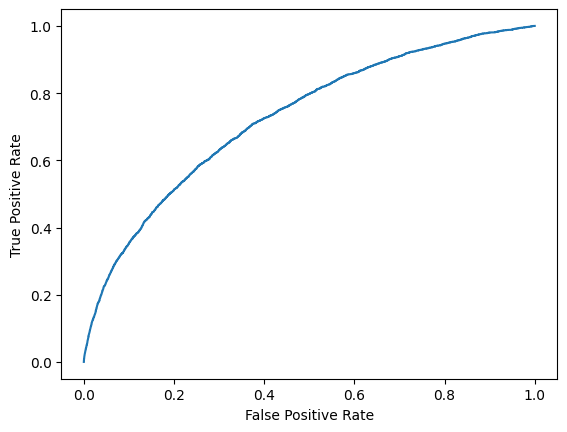

In [46]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve (y_val, val_preds)
auc = metrics.roc_auc_score (y_val, val_preds)

#create ROC curve
plt.plot (fpr,tpr,label=" AUC= "+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Создание и обучение модели Random Forest
model_rf = RandomForestClassifier(n_estimators=100,
                                  max_depth=7,
                                  random_state=0,
                                  class_weight='balanced')  # учет дисбаланса классов

# Обучение модели
model_rf.fit(X_train, y_train)

# Получение предсказаний на валидационном наборе данных
val_preds_rf = model_rf.predict_proba(X_val)[:, 1]

# Вычисление ROC-AUC на валидационном наборе данных
roc_auc_rf = roc_auc_score(y_val, val_preds_rf)
print("ROC-AUC на валидационном наборе данных (Random Forest):", roc_auc_rf)

KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Создание и обучение модели Gradient Boosting
model_gb = GradientBoostingClassifier(n_estimators=1500,
                                      learning_rate=0.08,
                                      max_depth=7,
                                      random_state=0)

# Обучение модели
model_gb.fit(X_train, y_train)

# Получение предсказаний на валидационном наборе данных
val_preds_gb = model_gb.predict_proba(X_val)[:, 1]

# Вычисление ROC-AUC на валидационном наборе данных
roc_auc_gb = roc_auc_score(y_val, val_preds_gb)
print("ROC-AUC на валидационном наборе данных (Gradient Boosting):", roc_auc_gb)

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Создание и обучение модели SVM
model_svm = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=0)

# Обучение модели
model_svm.fit(X_train_scaled, y_train)

# Получение предсказаний на валидационном наборе данных
val_preds_svm = model_svm.predict_proba(X_val_scaled)[:, 1]

# Вычисление ROC-AUC на валидационном наборе данных
roc_auc_svm = roc_auc_score(y_val, val_preds_svm)
print("ROC-AUC на валидационном наборе данных (SVM):", roc_auc_svm)

In [61]:
from sklearn.linear_model import LogisticRegression

# Создание и обучение модели Logistic Regression
model_lr = LogisticRegression(class_weight='balanced', random_state=0)

# Обучение модели
model_lr.fit(X_train, y_train)

# Получение предсказаний на валидационном наборе данных
val_preds_lr = model_lr.predict_proba(X_val)[:, 1]

# Вычисление ROC-AUC на валидационном наборе данных
roc_auc_lr = roc_auc_score(y_val, val_preds_lr)
print("ROC-AUC на валидационном наборе данных (Logistic Regression):", roc_auc_lr)


/home/andrew/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC на валидационном наборе данных (Logistic Regression): 0.7269044705981338


In [63]:
from sklearn.neighbors import KNeighborsClassifier

# Создание и обучение модели KNN
model_knn = KNeighborsClassifier(n_neighbors=5)

# Обучение модели
model_knn.fit(X_train, y_train)

# Получение предсказаний на валидационном наборе данных
val_preds_knn = model_knn.predict_proba(X_val)[:, 1]

# Вычисление ROC-AUC на валидационном наборе данных
roc_auc_knn = roc_auc_score(y_val, val_preds_knn)
print("ROC-AUC на валидационном наборе данных (KNN):", roc_auc_knn)


KeyboardInterrupt: 

In [65]:
%pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 18.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [68]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# Создание модели XGBoost
model_xgb = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=0)

# Обучение модели с выводом логов и графика
eval_set = [(X_train, y_train), (X_val, y_val)]  # Указываем обучающий и валидационный наборы данных
model_xgb.fit(X_train, y_train, eval_set=eval_set, eval_metric="auc", verbose=True)

# Получение предсказаний на валидационном наборе данных
val_preds_xgb = model_xgb.predict_proba(X_val)[:, 1]

# Вычисление ROC-AUC на валидационном наборе данных
roc_auc_xgb = roc_auc_score(y_val, val_preds_xgb)
print("ROC-AUC на валидационном наборе данных (XGBoost):", roc_auc_xgb)


/home/andrew/.local/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.75113	validation_1-auc:0.73264
[1]	validation_0-auc:0.75455	validation_1-auc:0.73512
[2]	validation_0-auc:0.75519	validation_1-auc:0.73571
[3]	validation_0-auc:0.75767	validation_1-auc:0.73644
[4]	validation_0-auc:0.75835	validation_1-auc:0.73657
[5]	validation_0-auc:0.75913	validation_1-auc:0.73726
[6]	validation_0-auc:0.75946	validation_1-auc:0.73690
[7]	validation_0-auc:0.75989	validation_1-auc:0.73712
[8]	validation_0-auc:0.76135	validation_1-auc:0.73805
[9]	validation_0-auc:0.76170	validation_1-auc:0.73835
[10]	validation_0-auc:0.76213	validation_1-auc:0.73883
[11]	validation_0-auc:0.76249	validation_1-auc:0.73911
[12]	validation_0-auc:0.76320	validation_1-auc:0.73963
[13]	validation_0-auc:0.76354	validation_1-auc:0.73980
[14]	validation_0-auc:0.76386	validation_1-auc:0.73984
[15]	validation_0-auc:0.76421	validation_1-auc:0.73985
[16]	validation_0-auc:0.76479	validation_1-auc:0.74008
[17]	validation_0-auc:0.76535	validation_1-auc:0.74028
[18]	validation_0-au